In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [16]:
## inspect schema
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])
    
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
## query dates and find last 12
last_date =  (session.query(Measurement.date).order_by(Measurement.date.desc()).first())
## print(last_date) ---> ('2017-08-23',)

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
## print(year_ago) ---> 2016-08-23

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).order_by(Measurement.date).all()
## print(precip_scores) ---> prints dates and precipition scores

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_scores, columns = ['date', 'precipitation'])
precip_df.set_index('date',inplace = True)
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


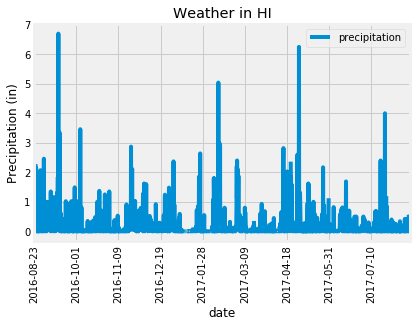

In [43]:
# Sort the dataframe by date
precip_df.sort_values(by = ['date'])

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=90).set_title("Weather in HI")
plt.ylabel("Precipitation (in)")
plt.show()

In [44]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [45]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).distinct().count()
print(stations)

9


In [59]:
# What are the most active stations? (i.e. what stations have the most rows)? And list the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Using the station id from the previous query, calculate the lowest temperature recorded
top_station = "USC00519281"
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == top_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
# highest temperature recorded, and average temperature of the most active station?
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [81]:
# Choose the station with the highest number of temperature observations.
temp_observs = (session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).all())
temp_observs

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [91]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12_temps = (session.query(Measurement.date, Measurement.tobs).order_by(Measurement.date)
                   .filter(Measurement.date >= year_ago)
                   .filter(Measurement.station == top_station)
                   .all())
temps_sum = pd.DataFrame(last12_temps)
temps_sum = temps_sum.set_index("date").sort_index(ascending=True)

temps_sum

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


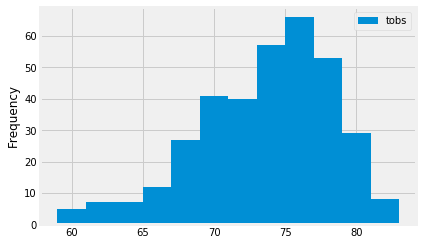

In [94]:
## Histogram
fig, ax = plt.subplots()
temps_sum.plot.hist(bins = 12, ax = ax)

In [95]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [100]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
trip = calc_temps('2017-02-28', '2017-03-05')
# for your trip using the previous year's data for those same dates.
print(f"tmin {trip[0][0]} Fahrenheit")
print(f"tavg: {round(trip[0][1], 2)} Fahrenheit")
print(f"tmax: {trip[0][2]} Fahrenheit")

tmin 64.0 Fahrenheit
tavg: 72.03 Fahrenheit
tmax: 78.0 Fahrenheit


Text(0, 0.5, 'Temp in F')

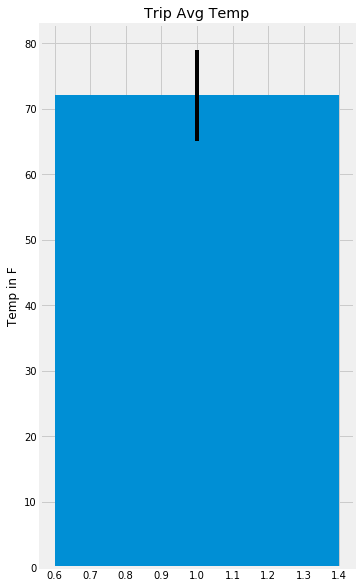

In [113]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
pk_to_pk = trip[0][2] - trip[0][0]
trip_avg_temp = trip[0][1]

fig, ax = plt.subplots(figsize = (5, 10))
ax.bar(1, trip_avg_temp, yerr = pk_to_pk/2)
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temp in F")

In [116]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


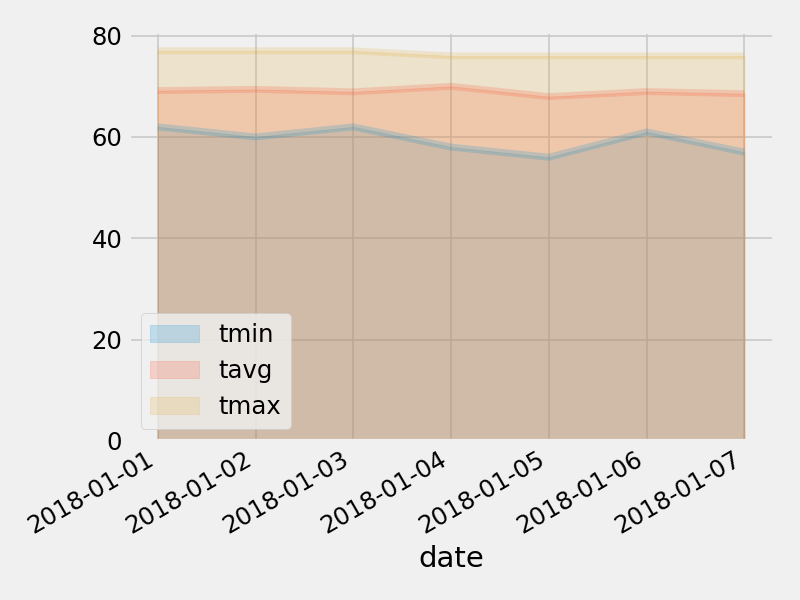

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
